## **Predicting Transportation price from macroeconomic conditions**

In this notebook, we present a comprehensive machine learning framework for the prediction of intercity transportation prices. While transportation pricing is determined by a multitude of factors, including climatic conditions, road infrastructure availability, and policy decisions by relevant regulatory authorities, a considerable degree of stochasticity persists, owing to the intricate interdependencies among these variables. This study seeks to rigorously assess the feasibility and potential benefits of incorporating macroeconomic indicators specifically, inflation rate, exchange rate, government subsidies, and crude oil prices as explanatory variables within a supervised learning approach, with the aim of enhancing the accuracy and robustness of transportation price predictions.

#### **Importing relevent libaries**

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from bayes_opt import BayesianOptimization as bayes
import joblib
import warnings

warnings.filterwarnings('ignore')

### **Data Acquisition and Description**

Our dataset was obtained from the [National Bureau of Statistics](https://www.nigerianstat.gov.ng/).


### **Aim**

The principal agency responsible for the collection, analysis, and dissemination of official statistical data in Nigeria. The National Bureau of Statistics provides a comprehensive repository of high-quality, systematically curated data covering a wide range of socio-economic indicators, including but not limited to transportation metrics, macroeconomic variables, and price indices. Utilising data from this authoritative source ensures the reliability, credibility, and empirical validity of our subsequent analyses.

#### **Load Data**

In [ ]:
# load csv file with pandas
data = pd.read_csv('Transport_pricing.csv')
# creating a copy
df = data.copy()
df.head()

,Month,Intercity transport fare (#),Crude Oil Price ($),Exchange rate,Inflation rate (%),Subsidy
0,Jan-72,8.0,3.39,0.66,3.46,0
1,Feb-72,10.0,3.39,0.66,3.46,0
2,Mar-72,12.0,3.39,0.66,3.46,0
3,Apr-72,14.0,3.39,0.66,3.46,0
4,May-72,16.0,3.39,0.66,3.46,0


We would do a summarization of our data to check the relevent information and possibly hidden details.

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Month                         636 non-null    object 
 1   Intercity transport fare (#)  635 non-null    float64
 2   Crude Oil Price ($)           636 non-null    float64
 3   Exchange rate                 636 non-null    float64
 4   Inflation rate (%)            636 non-null    float64
 5   Subsidy                       636 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 29.9+ KB


In [54]:
# check for the number of unique values in each column
df.nunique()

Month                           636
Intercity transport fare (#)    554
Crude Oil Price ($)              53
Exchange rate                    64
Inflation rate (%)               51
Subsidy                           2
dtype: int64

### **Data Preprocessing**

In [55]:
# standardize column names 
new_col = df.columns.str.replace(' ', '_').str.lower()
df.columns = new_col

In [56]:
# remname month to date 
df.rename(columns={'month': 'Date'}, inplace=True)

In [57]:
# convert data columns to datatime format
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')

In [58]:
# create new column for month
df['month'] = df['Date'].dt.month

**Categorical variable encoding**

Subsidy status is a non‑ordinal categorical variable, since its two categories: **“subsidy”** and **“no subsidy”**, have no inherent ordering or ranking; one cannot be considered “greater” or “less” than the other they represent distinct, equally valid states.To incorporate such nominal variables into machine learning models, we use one-hot encoding.

**One-hot encoding** is a preprocessing technique in machine learning that transforms categorical data into a numerical format by creating a separate binary (dummy) feature for each unique category. For any given observation, exactly one feature corresponding to its category (subsidy) is set to 1, while all other category features (no subsidy) are set to 0. This approach preserves the independence of categories and avoids introducing any artificial rank or ordinal relationship among them.


In [59]:
encoder = OneHotEncoder()
subsidy_encoded = encoder.fit_transform(df[['subsidy']])
df = df.join(pd.DataFrame(subsidy_encoded.toarray(), columns=encoder.get_feature_names_out(['subsidy'])))
df.drop(columns=['subsidy'], inplace=True)

### **Feature Engineering**
**Features** are individual measurable properties or characteristics of a phenomenon being observed; in machine learning, they serve as the primary inputs that drive predictive modeling. The selection and construction of meaningful features is critical, as the quality and relevance of features directly influence model performance and the accuracy of predictions.

**Feature engineering** is the process of creating, transforming, or selecting features to enhance a model’s ability to capture underlying patterns in the data. Effective feature engineering can reveal hidden relationships, reduce noise, and significantly improve the predictive power of machine learning algorithms. The features engineered include:

1. **Relative Purchasing Power Parity (RPPP)** is an economic theory that relates the rate of change in the exchange rate between two currencies to the difference in their inflation rates. In essence, it says that currencies will depreciate (or appreciate) just enough to offset inflation differentials, so that a basket of goods costs the same in both countries once converted.

2. **Oil local**: Converts the global oil price into your local‐currency terms, capturing the true cost burden on transport operators who pay in local currency directly tying fuel input costs to fare pricing.

3. **Oil real**: Adjusts the nominal oil price for general price‐level changes, so you’re modeling the real cost of fuel over time separating pure oil‐market swings from broader inflationary trends.

In [60]:
df['oil_local'] = df['crude_oil_price_($)'] * df['exchange_rate']
df['oil_real'] = df['crude_oil_price_($)'] / (1 + df['inflation_rate_(%)']/100)
df['rppp_deviation'] = np.log(df['exchange_rate']).diff() - df['inflation_rate_(%)'] / 100

In [61]:
# numerical columns
num_col = [col for col in df.columns if col not in ["Date", "month", "subsidy_0", "subsidy_1"]]

In [62]:
# utility function to plot histogram and KDE for each column with skewness and kurtosis in the legend.

def plot_kde_with_stats(df, num_col, ncols=2, figsize=(18, 20)):
    nrows = (len(num_col) + 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True)
    axes = axes.flatten()

    for i, col in enumerate(num_col):
        ax = axes[i]
        skew_val = skew(df[col])
        kurt_val = kurtosis(df[col])

        sns.histplot(df[col], kde=True, stat='density', bins='fd',
                     ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(col)
        ax.legend([f"Skew: {skew_val:.2f}\nKurtosis: {kurt_val:.2f}"])
        ax.grid(True, alpha=0.2)

    fig.tight_layout()
    plt.show()

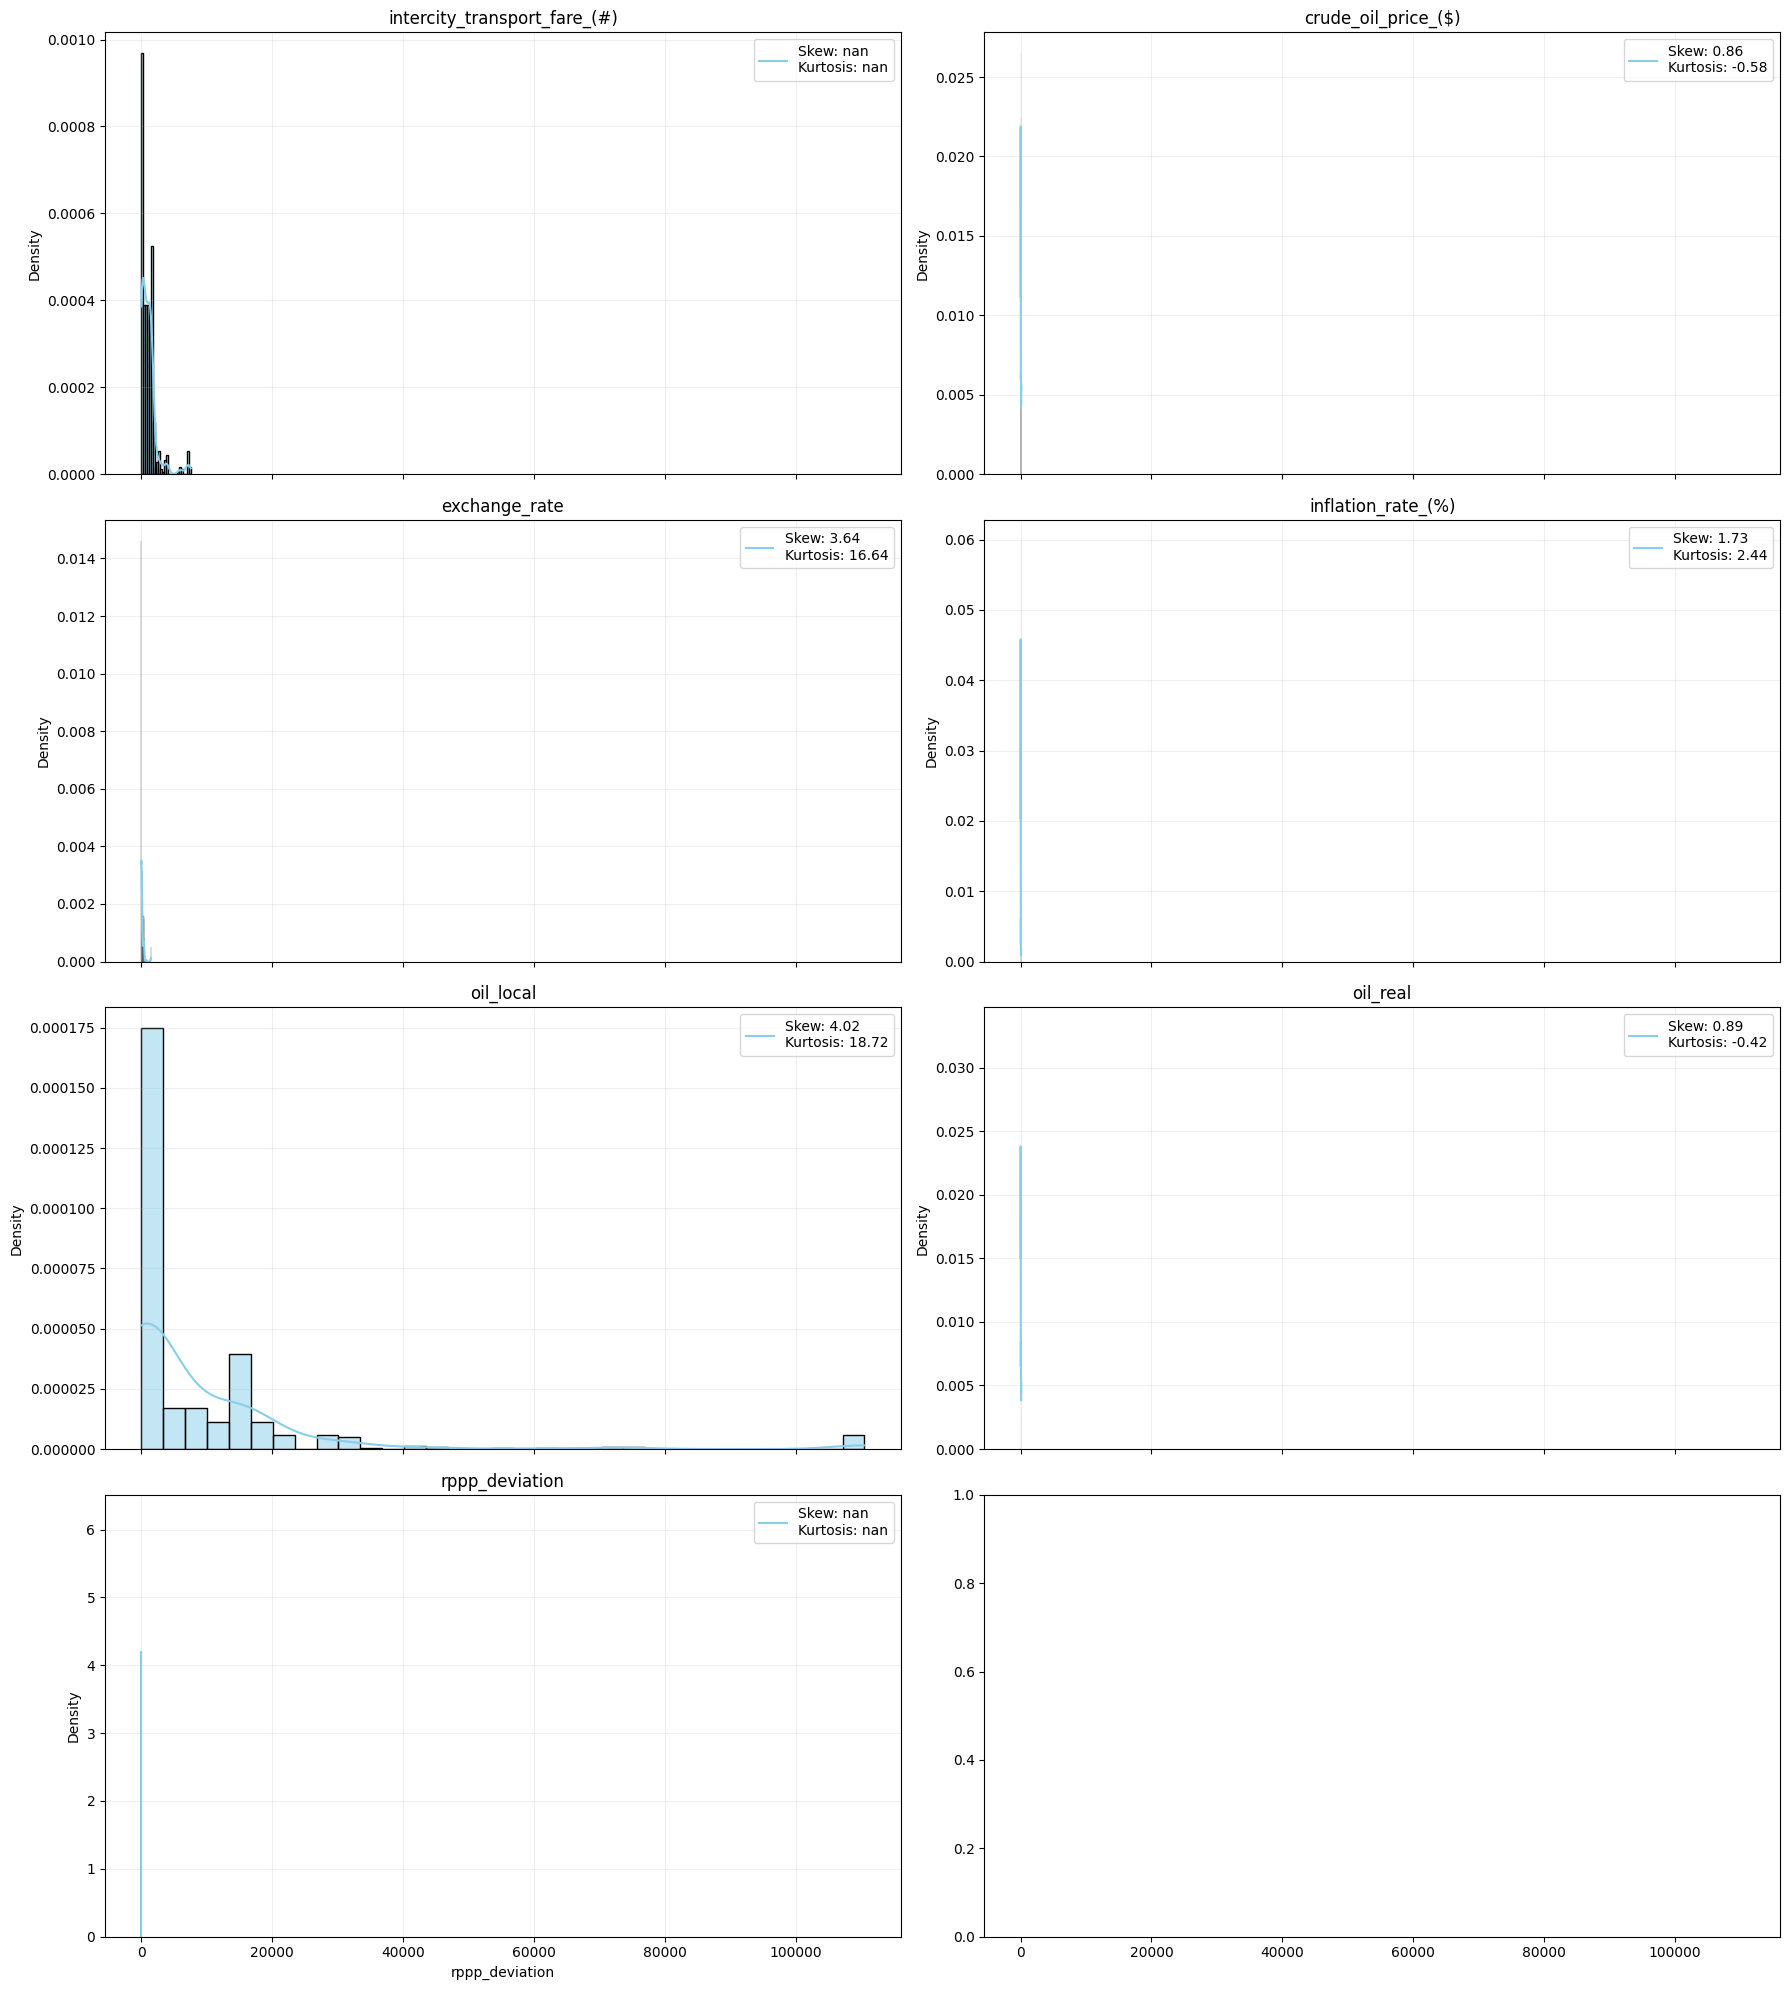

In [63]:
# plot distribution of numerical columns
plot_kde_with_stats(df, num_col)

**Observation:** All features are left skewed. fofr convergence stability and optimization (including model training speed). we would have to make sure these features are normalized by applying the yeo-johnson power transformation.

In [64]:
pt = PowerTransformer(method='yeo-johnson')
df[num_col] = df[num_col].apply(lambda x: pt.fit_transform(np.array(x).reshape(-1, 1)).flatten())

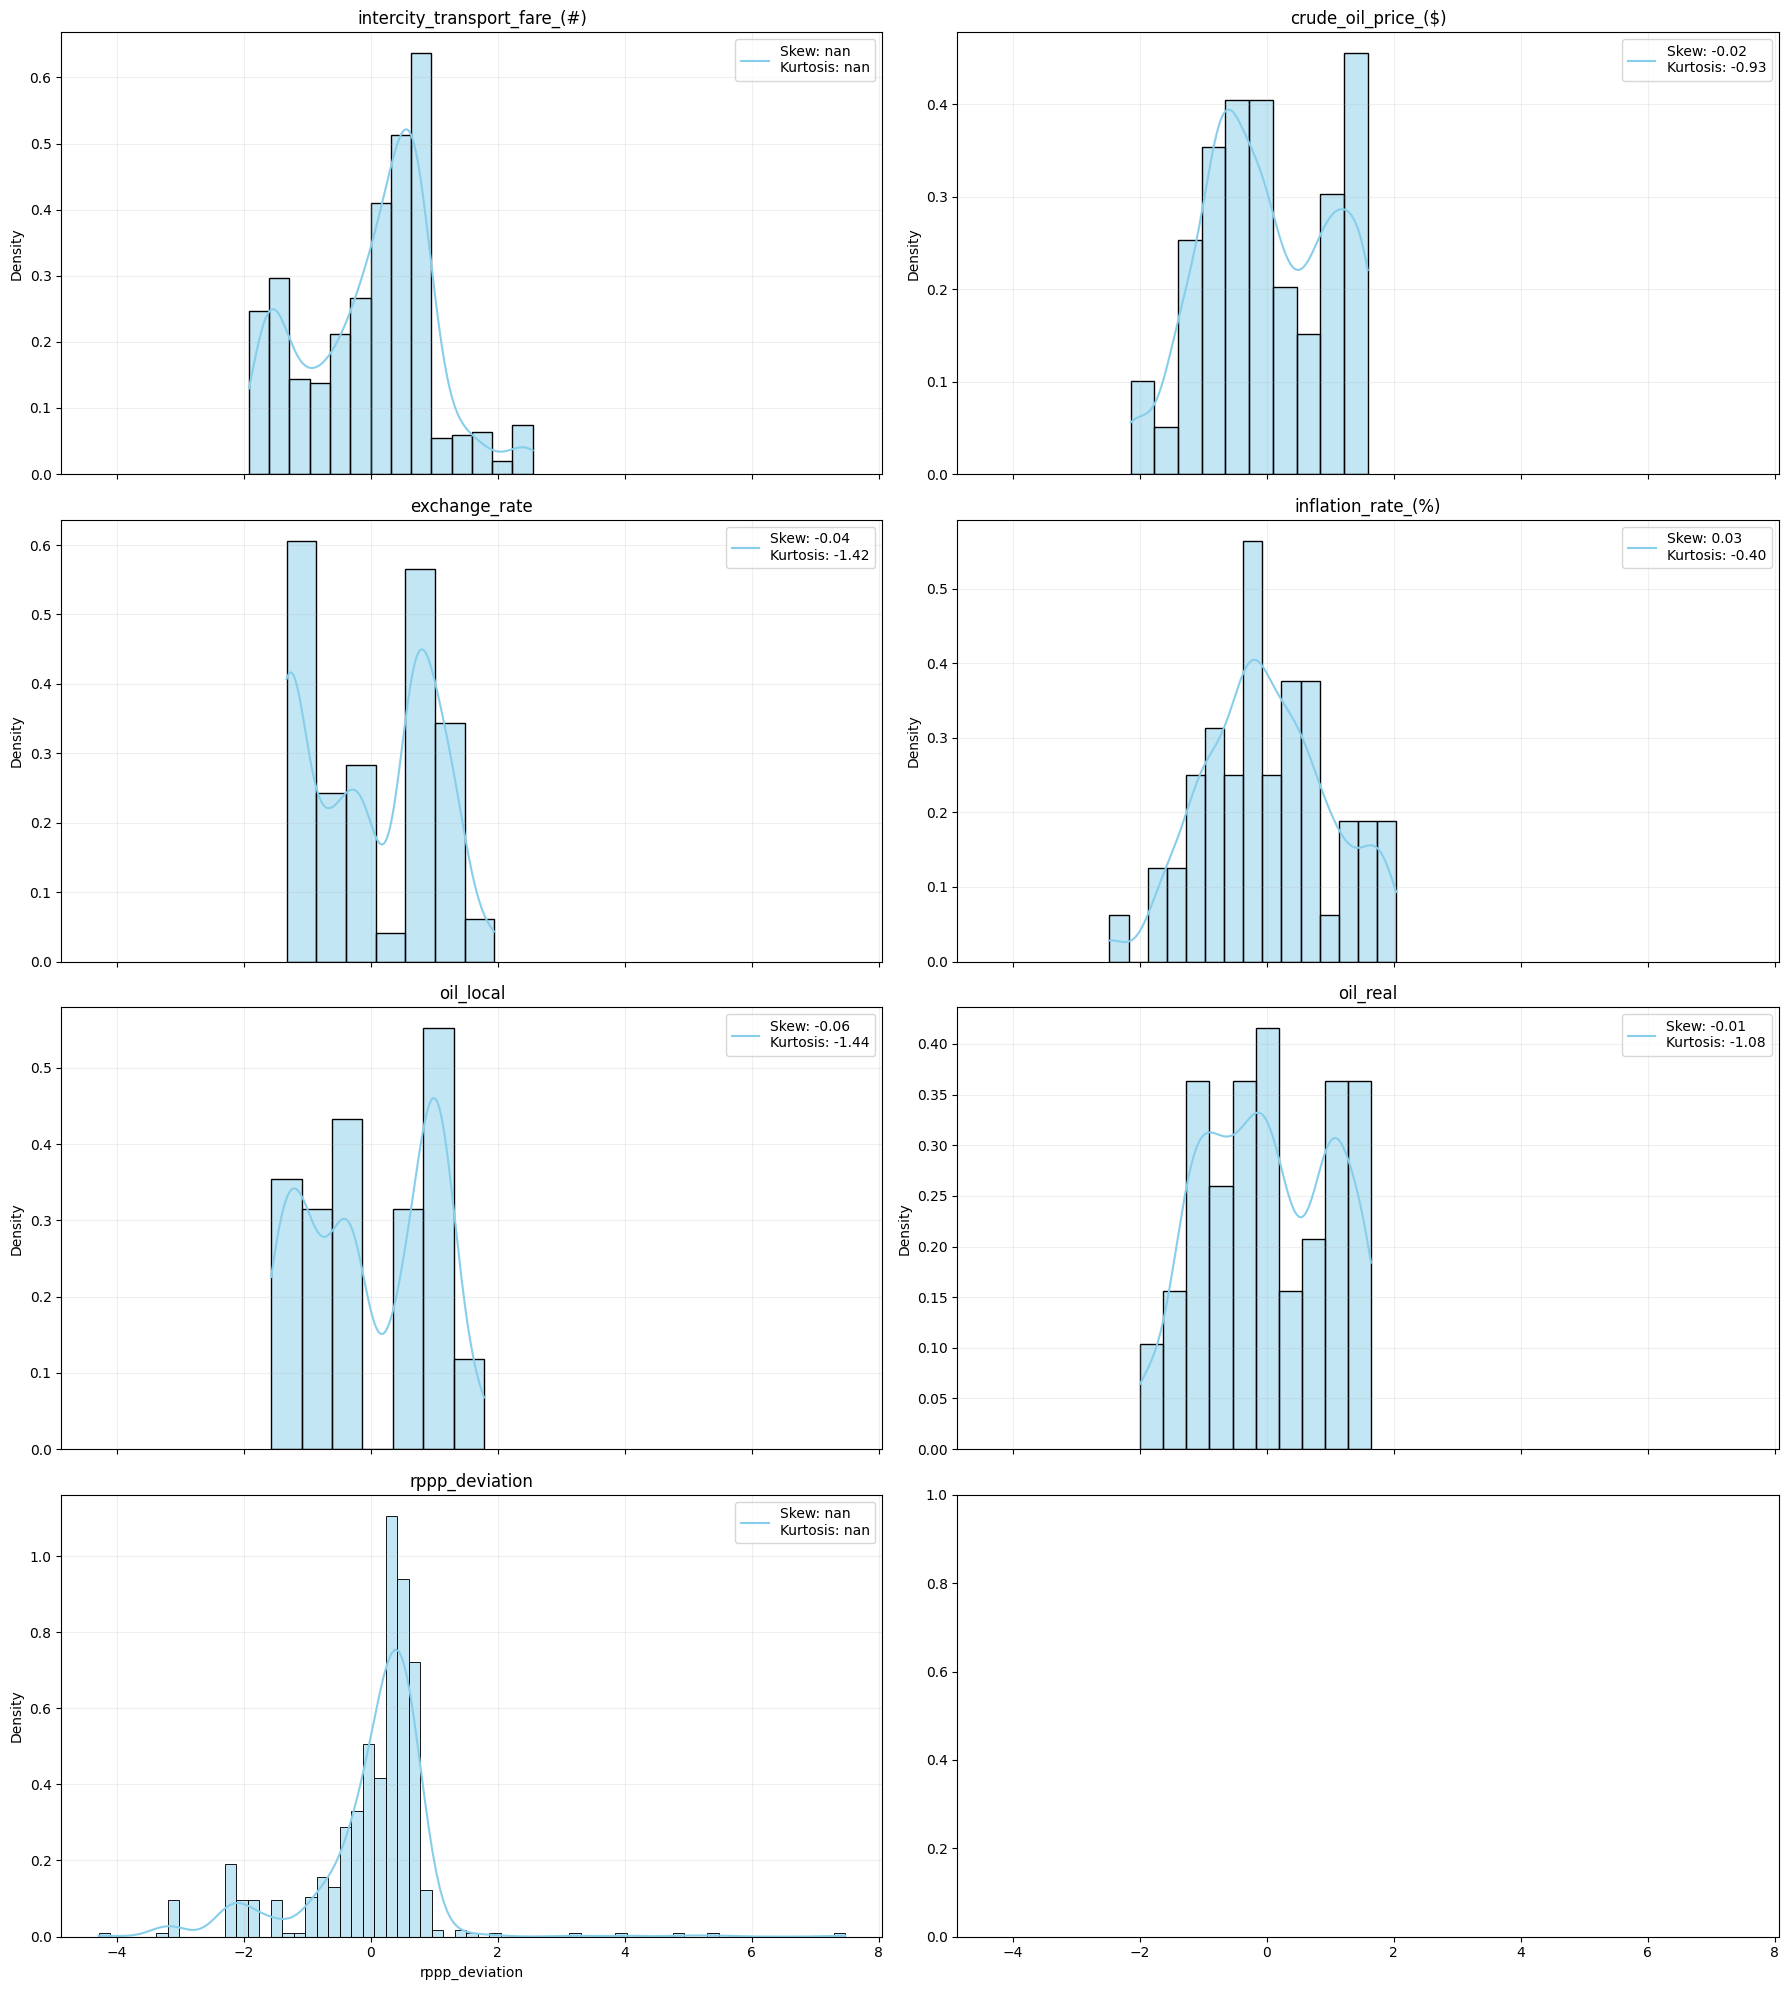

In [65]:
# replot the distributions after transformation
plot_kde_with_stats(df, num_col)

### **Correlation Analysis**
It would be of importance to us if we know what degree of correlation exist between our data while bearing in mind that correlation is not causation. Two ways to do this is using:

1. A pair-plot.
2. Correlation Matrix (using pearson correlation).

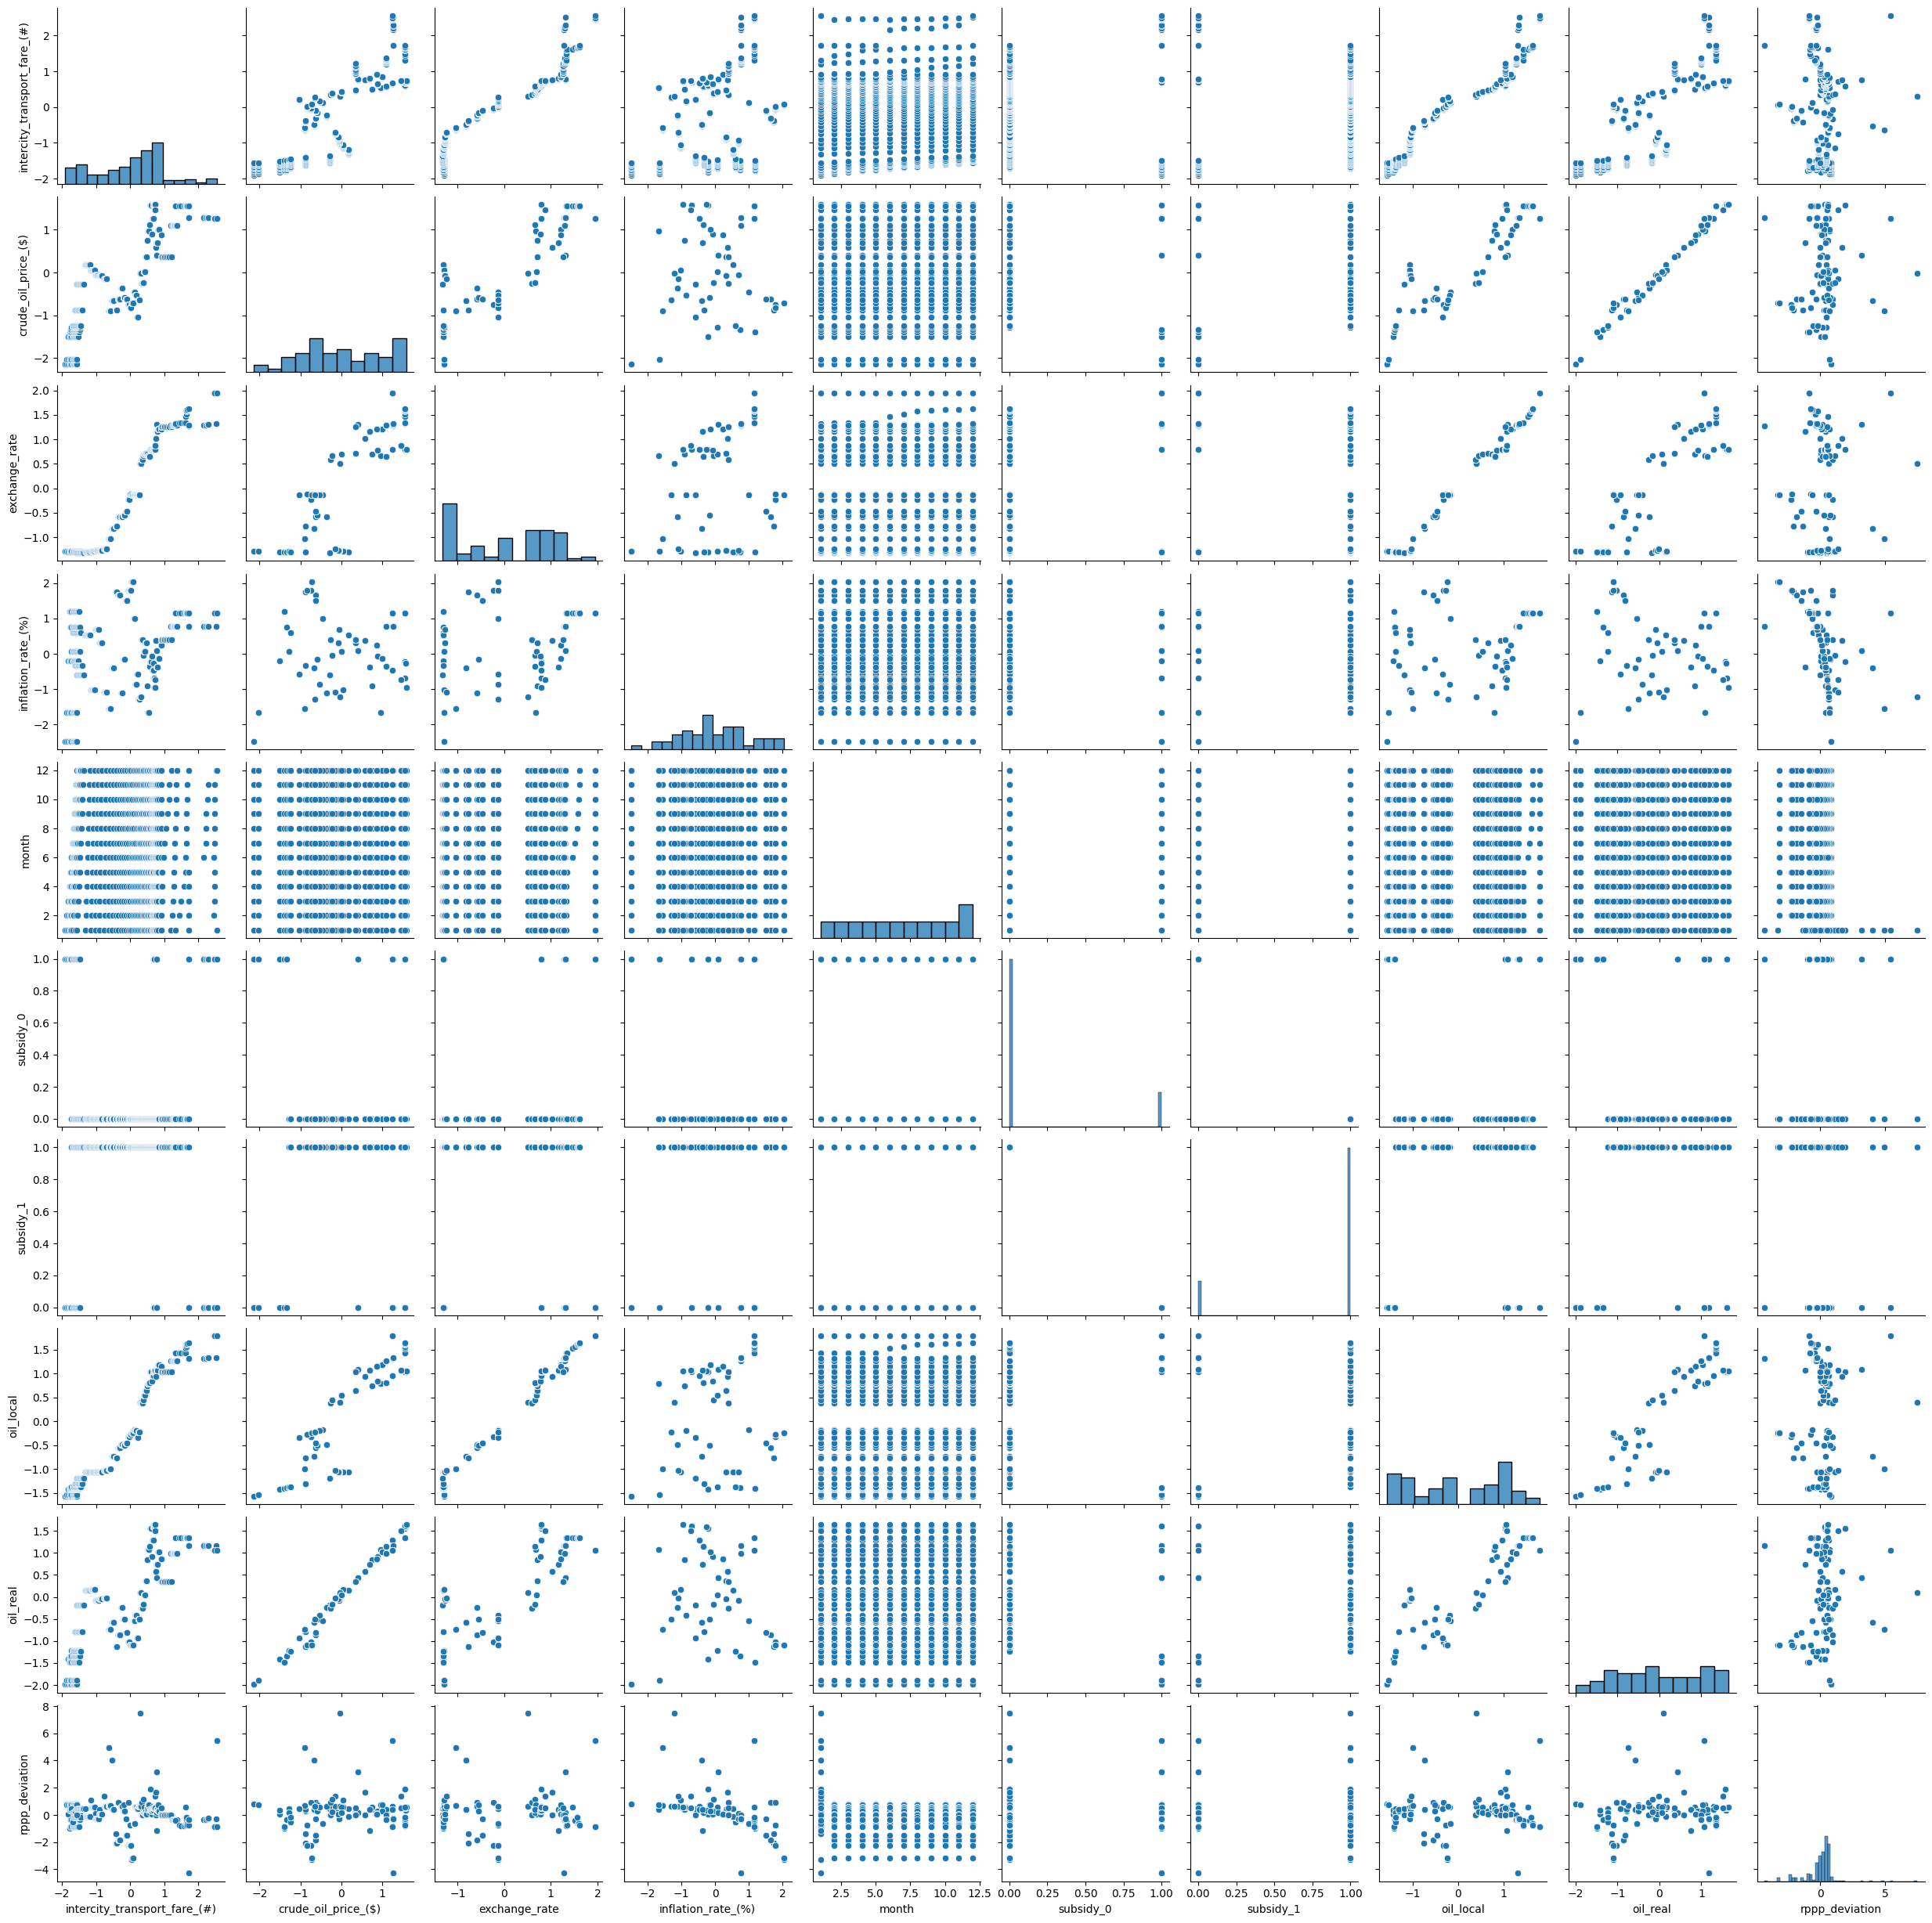

In [66]:
# pairplot to visualize relationships between numerical featurese
sns.pairplot(df.select_dtypes(include='number'))
plt.show()

<Axes: >

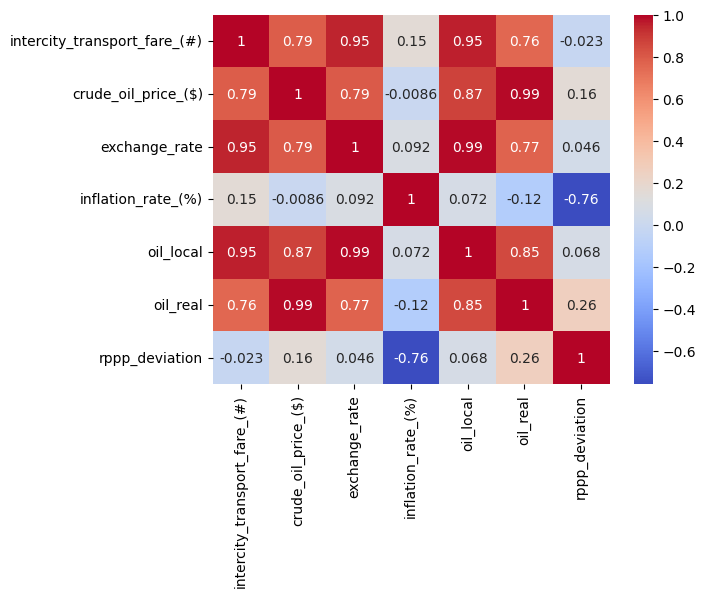

In [67]:
# correlation matrix using an heatmap
sns.heatmap(df[num_col].corr(), annot=True, cmap="coolwarm")

In [68]:
# one-hot encoding month.
df = pd.get_dummies(df, columns=['month'], drop_first=True, dtype=int)

In [ ]:
df.dropna(inplace=True)
df.drop(columns=['Date'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 1 to 635
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   intercity_transport_fare_(#)  634 non-null    float64
 1   crude_oil_price_($)           634 non-null    float64
 2   exchange_rate                 634 non-null    float64
 3   inflation_rate_(%)            634 non-null    float64
 4   subsidy_0                     634 non-null    float64
 5   subsidy_1                     634 non-null    float64
 6   oil_local                     634 non-null    float64
 7   oil_real                      634 non-null    float64
 8   rppp_deviation                634 non-null    float64
 9   month_2                       634 non-null    int64  
 10  month_3                       634 non-null    int64  
 11  month_4                       634 non-null    int64  
 12  month_5                       634 non-null    int64  
 13  month_6   

### **Modelling**

#### **Data splitting**

In [71]:
# separate features and target variable, then split the data into training and testing sets.
features = [col for col in df.columns if col != 'intercity_transport_fare_(#)']
target   = 'intercity_transport_fare_(#)'
X = df[features]
y = df[[target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Transformation and normalization pipeline
numeric_cols = [col for col in num_col if col in X_train.columns]
cat_cols = [col for col in X_train.columns if col not in numeric_cols]

# using standard scaler to transform numerical features while leaving categorical features unchanged.
stdsc = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', stdsc, numeric_cols),
        ('cat', 'passthrough', cat_cols),
    ]
)
# scaling features
X_train_norm = preprocessor.fit_transform(X_train)
X_test_norm  = preprocessor.transform(X_test)

In [73]:
print(f"shape of X_train_norm: {X_train_norm.shape}")
print(f"shape of X_test_norm: {X_test_norm.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X_train_norm: (507, 19)
shape of X_test_norm: (127, 19)
shape of y_train: (507, 1)
shape of y_test: (127, 1)


In [74]:
# scaling the target variable
stdsc_test = StandardScaler()
y_train_norm = stdsc_test.fit_transform(y_train)
y_test_norm = stdsc_test.transform(y_test)

#### **Baseline Model (Linear Regression)**

The Linear Regression model would be use as a baseline model to establish minimum performance and get a quick glance at the feasibility of Machine learning to optimize transport price prediction. Linear Regression is a popular choice as a regression baseline model as it is fast, easy and interpretable.

In [75]:
# Instantiate Linear regression model object
lr = LinearRegression()
# Fit the model on trainging data
lr.fit(X_train, y_train)

# Predict in training data and test data
y_pred_train = lr.predict(X_train) 
y_pred_test  = lr.predict(X_test)



After fitting the model we would go ahead to evaluate the performance of our models using a dedicated set of metrics.

#### **Model Evaluation**
The three main primary evaluation metrics employed in determining the performance of a supervised regression model include:

1. **Coefficient of Determination (R²)**: This quantifies the proportion of variance in the dependent variable that is predictable in from the independent variables. It measures the goodness of fit of a model and ranges from 0 to 1 with 1 representing a model that perfectly fits our data.

2. **Mean Absolute Error (MAE)**: This quantifies the average absolute difference between the predicted and actual value. 

3. **Root Mean Square Error (RMSE)**: This quantifies the standard deviation of errors from our prediction. 

In [76]:
# Evaluate model performance using R², MAE, and RMSE
print("Training set performance:")
print(f"  R²:   {r2_score(y_train, y_pred_train):.4f}")
print(f"  MAE: {np.sqrt(mean_absolute_error(y_train, y_pred_train)):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")

print("\nTest set performance:")
print(f"  R²:   {r2_score(y_test, y_pred_test):.4f}")
print(f"  MAE:  {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")


Training set performance:
  R²:   0.9345
  MAE: 0.4411
  RMSE: 0.2544

Test set performance:
  R²:   0.9383
  MAE:  0.1851
  RMSE: 0.2516


#### **Visualising Model Performance**

We can visualize our model performance by ploting our preicted against actual value and checking for a high degree of linearity. In our case this is evident and we can confirm that **The linear regression model did well on our preprocessed data**.

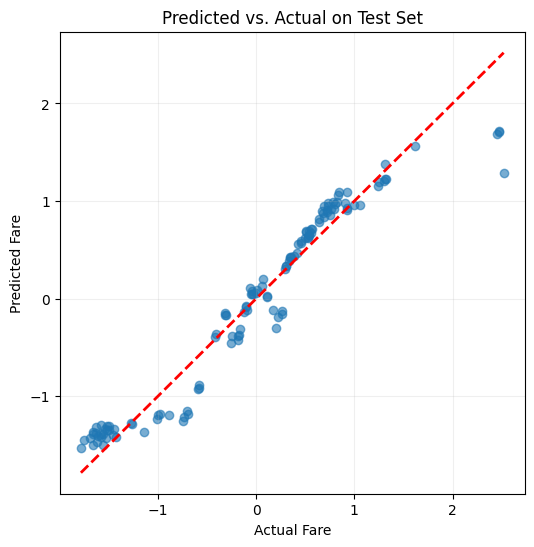

In [77]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Predicted vs. Actual on Test Set")
plt.grid(alpha=0.2)
plt.show()

**Observation:** While the linear regression model did well, it still surffers in terms of Mean Absolute error and this is the most important metric for determining the performance of our regression model so we will go ahead and try to increase the performance by choosing a more robust model called the **Random Forest** and we would select the most important features to train our model. 

**Random Forest Regression** works by combining the outputs of multiple [decision trees](https://en.wikipedia.org/wiki/Decision_tree_model/) each trained on a random subset of our training data data. Random forest performs bootstrap sampling where each decision tree created has it own trainig dataset which is a random selction of rows of our trainig data this helps to increase model diversity.

The Random Forest Regression model is popular as it posses the capabilty to obtaining the importance and predictive ability of each features based on [Mean Distance Impurity](https://en.wikipedia.org/wiki/Random_forest). 

In [ ]:
# get feature importance with random forest.
forest = RandomForestRegressor(n_estimators=200, random_state=42)
forest.fit(X_train, y_train.values.ravel())
importances = forest.feature_importances_
forest_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

In [79]:
forest_importances

,feature,importance
0,oil_local,0.646842
1,exchange_rate,0.317496
2,crude_oil_price_($),0.016479
3,oil_real,0.005667
4,subsidy_1,0.004334
5,subsidy_0,0.003802
6,inflation_rate_(%),0.002204
7,rppp_deviation,0.001916
8,month_2,0.000237
9,month_12,0.000223


**Observation:** Based on relative importance of each feature it is best we drop the month dta because of irrelevance. But we notice that festive seasons and 4th quater of the month have a little correlation with transport price as expected but we would drop then as we would require our model to generalize well on only important features.

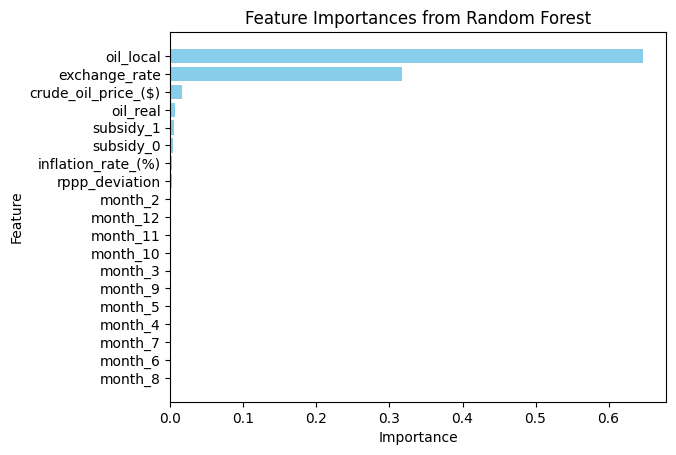

In [80]:
# visualize feature importnaces
plt.title("Feature Importances from Random Forest")
plt.barh(forest_importances['feature'], forest_importances['importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [81]:
sfm = SelectFromModel(forest, threshold=0.002, prefit=True)
X_selected = sfm.transform(X_train)
print("Number of important features based the threshold we picked from our random forest is:", X_selected.shape[1])

Number of important features based the threshold we picked from our random forest is: 7


### **Modelling: Random Forest Model**

A class has been constructed to manage all of the underlying work such as fine-tunning, standardizing and evaluating model for a more compact and reproducible work.

In [82]:
class Model:
    def __init__(self):
        # Pipeline with scaling + RF
        self.model = RandomForestRegressor(random_state=42)
        self.pipeline = make_pipeline(StandardScaler(), self.model)

    def tune(self, X, y, init_points=5, n_iter=25):
        # Our optimization objective is to reduce MAE (by maximizing negative MAE)
        def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
            params = {
                'n_estimators': int(n_estimators),
                'max_depth': int(max_depth),
                'min_samples_split': int(min_samples_split),
                'min_samples_leaf': int(min_samples_leaf)
            }
            self.model.set_params(**params)
            score = cross_val_score(
                self.pipeline, X, y,
                scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                cv=3, n_jobs=-1
            ).mean()
            # SCORE IS NEGATIVE MAE
            return score

        # Set bounds to search for optimal parameter
        pbounds = {
            'n_estimators': (50, 500),
            'max_depth': (5, 30),
            'min_samples_split': (2, 20),
            'min_samples_leaf': (1, 10)
        }

        optimizer = bayes(
            f=rf_cv,
            pbounds=pbounds,
            random_state=42,
            verbose=2
        )
        optimizer.maximize(init_points=init_points, n_iter=n_iter)

        # Extracting and setting our best params
        best = optimizer.max['params']
        best_int = {
            'n_estimators': int(best['n_estimators']),
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf'])
        }
        self.model.set_params(**best_int)
        print("Best hyperparameters:", best_int)

    def train(self, X_train, y_train):
        self.pipeline.fit(X_train, y_train)

    def cross_validate(self, X, y, cv=3):
        maes = -cross_val_score(
            self.pipeline, X, y,
            scoring='neg_mean_absolute_error',
            cv=cv,
        )
        print(f"CV MAE: {maes.mean():.4f} ± {maes.std():.4f}")

    def evaluate(self, X, y, dataset_name="Dataset"):
        """Evaluate R², MAE, and RMSE on given data."""
        y_pred = self.pipeline.predict(X)
        r2   = r2_score(y, y_pred)
        mae  = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        print(f"{dataset_name} performance:")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        return y_pred



In [83]:
model = Model()
model.tune(X_train, y_train, init_points=3, n_iter=10)
model.cross_validate(X_train, y_train, cv=3)
model.train(X_train, y_train)
model.evaluate(X_test, y_test, dataset_name="Test Set")

|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------------------


| 1         | -0.051446 | 218.54305 | 28.767857 | 15.175890 | 6.3879263 |
| 2         | -0.058436 | 120.20838 | 8.8998630 | 3.0455050 | 8.7955853 |
| 3         | -0.064866 | 320.50175 | 22.701814 | 2.3705208 | 9.7291886 |
| 4         | -0.053217 | 219.16952 | 28.570172 | 15.571137 | 7.2636868 |
| 5         | -0.045173 | 215.32929 | 29.350065 | 14.074058 | 2.1116827 |
| 6         | -0.024899 | 211.90683 | 30.0      | 4.9525893 | 1.0       |
| 7         | -0.025358 | 202.15419 | 30.0      | 2.0       | 1.0       |
| 8         | -0.025293 | 208.02741 | 14.932421 | 2.0       | 1.0       |
| 9         | -0.038384 | 185.56366 | 5.0       | 2.0       | 1.0       |
| 10        | -0.064670 | 499.66087 | 13.308230 | 16.937238 | 9.7952197 |
| 11        | -0.060000 | 409.36053 | 29.286049 | 18.647341 | 2.5242756 |
| 12        | -0.038381 | 227.93272 | 5.0       | 2.0       | 1.0       |
| 13        | -0.069257 | 171.91804 | 30.0      | 2.0       | 10.0      |
Best hyperparameters: {'n_estimators':

array([ 0.49787751, -0.11271312, -0.25154185,  0.34283392,  0.79402043,
        0.57119643,  1.33206441, -0.11271312, -1.57430982, -0.32906775,
        0.0639628 , -1.60214582, -0.61179771, -1.51272119, -0.11271312,
        0.33993366, -1.74478844,  0.57119643, -0.25154185, -1.67154584,
       -0.10955536,  0.49774274, -0.17272537, -1.22887814,  1.33206441,
        0.77510939,  0.53184153,  0.71810928, -0.86131792,  0.79402043,
        0.53179647,  0.01046432,  0.83157114,  0.42340517,  0.71822331,
       -0.95825894, -1.45225751, -1.4865761 ,  0.75653113,  0.83157114,
        0.53182976,  0.46266188,  0.75653113, -1.6615366 , -0.95825894,
       -1.68368288,  0.25400556, -0.05191713, -0.61179771, -0.4038442 ,
        0.53182976, -0.05191713,  0.46168715,  0.11467693, -1.60996879,
        1.01154315, -0.05191713, -0.95825894,  1.01154315,  0.25400556,
        0.68526877, -1.61397641,  1.33083018,  0.30328286, -0.4038442 ,
       -1.62865702,  2.4720696 , -0.61179771, -1.53742836, -1.55

#### **Save final model**

In [84]:
joblib.dump(model.pipeline, "random_forest_pipeline.joblib")
print("Saved trained pipeline to random_forest_pipeline.joblib")


Saved trained pipeline to random_forest_pipeline.joblib


### **Final Results**

### **Conclusion**

### **Reference**